# Text-to-Image generation
With DeepFloyd



In [1]:
!grep MemTotal /proc/meminfo

MemTotal:       32880800 kB


In [2]:
!nvidia-smi

Thu Oct 24 21:50:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Installation

In [3]:
! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  safetensors~=0.3 \
  sentencepiece~=0.1 \
  accelerate~=0.18 \
  bitsandbytes~=0.38 \
  torch~=2.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.82 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
dask-cudf 23.8.0 requires dask==2023.7.1, but you have dask 2

In [4]:
from huggingface_hub import login

login()

## Text-to-image generation

### 1 Load text encoder

load T5 using 8bit quantization

In [85]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    load_in_8bit=True,
    variant="8bit"
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


### 2 Create text embeddings



In [86]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=text_encoder, # pass the previously instantiated 8bit text encoder
    unet=None,
    device_map="balanced"
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]


Text prompt:

In [87]:
# prompt = """create an image of a wooden chair with a dark brown finish. The chair has a solid, flat seat and four straight legs. 
# Its back features a simple, elegant design with two diagonal crossbars forming an "X" shape, supported by vertical and horizontal bars. The chair has a minimalist, 
# classic appearance, suitable for dining or casual seating. The background is a plain white, enhancing the chair visual prominence."""

# prompt = """
# Create en image of modern three-seater sofa with a minimalist design. It has a structured, rectangular 
# shape with clean lines and sharp edges. The sofa is upholstered in a smooth, grey fabric. The backrest consists of three separate cushions, matching 
# the darker grey seat cushions. The armrests are wide and slightly lower than the backrest. The sofa is elevated on four slim, angled legs, 
# giving it a mid-century modern look. The background is plain light grey, emphasizing the sofa's design.
# Make sure that the sofa is in the centre of the image. Make sure the top, bottom, and sides of the picture are indented from the edge. 
# """

prompt = """
Create a picture of a tall, wooden wardrobe with a minimalist design. It features two large doors on the top section, each with a recessed panel,
creating a simple and clean look. Below the doors are two horizontal drawers, each with two small round handles. The wardrobe has a flat top with a slight 
overhang and a flat base, adding to its sleek and contemporary appearance. The handles and knobs are metallic, contrasting subtly with the matte gray finish of the wardrobe.
The background is plain light grey, emphasizing the sofa's design. Make sure that the wardrobe is in the centre of the image. Make sure the top, bottom, and sides of the picture are indented from the edge.
"""

In [88]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["base, adding to its sleek and contemporary appearance. the handles and knobs are metallic, contrasting subtly with the matte gray finish of the wardrobe. the background is plain light grey, emphasizing the sofa's design. make sure that the wardrobe is in the centre of the image. make sure the top, bottom, and sides of the picture are indented from the edge."]


### 3 Free memory

In [89]:
del text_encoder
del pipe

In [90]:
import gc
import torch

def flush():
    gc.collect()
    torch.cuda.empty_cache()

In [91]:
flush()

### Stage 1: The main diffusion process

With our now available GPU memory, we can re-load the `DiffusionPipeline` with only the UNet to run the main diffusion process.

The `variant` and `torch_dtype` flags are used by Diffusers to download and load the weights in 16 bit floating point format.

In [92]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="balanced"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Let's define a random generator and run the stage 1 diffusion process.

In [93]:
generator = torch.Generator().manual_seed(3)
image = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/100 [00:00<?, ?it/s]

Let's manually convert the raw tensors to PIL and have a sneak peak at the final result. The output of stage 1 is a 64x64 image.

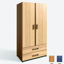

In [94]:
from diffusers.utils import pt_to_pil

pil_image = pt_to_pil(image)

pil_image[0]

In [95]:
del pipe
flush()

### Stage 2: Super Resolution 64x64 to 256x256

create pipeline

In [96]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
    text_encoder=None, # no use of text encoder => memory savings!
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="balanced"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

and run it, re-using the pre-computed text embeddings

In [97]:
image = pipe(
    image=image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Again we can inspect the intermediate results.

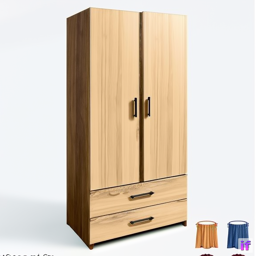

In [98]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

In [99]:
del pipe
flush()

### Stage 3: Super Resolution 256x256 to 1024x1024


In [100]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler",
    torch_dtype=torch.float16,
    device_map="balanced"
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-x4-upscaler/snapshots/572c99286543a273bfd17fac263db5a77be12c4c/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


In [101]:
pil_image = pipe(prompt, generator=generator, image=image).images

Token indices sequence length is longer than the specified maximum sequence length for this model (144 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["appearance . the handles and knobs are metallic , contrasting subtly with the matte gray finish of the wardrobe . the background is plain light grey , emphasizing the sofa 's design . make sure that the wardrobe is in the centre of the image . make sure the top , bottom , and sides of the picture are indented from the edge ."]
/opt/conda/lib/python3.10/site-packages/diffusers/image_processor.py:704: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

View output image

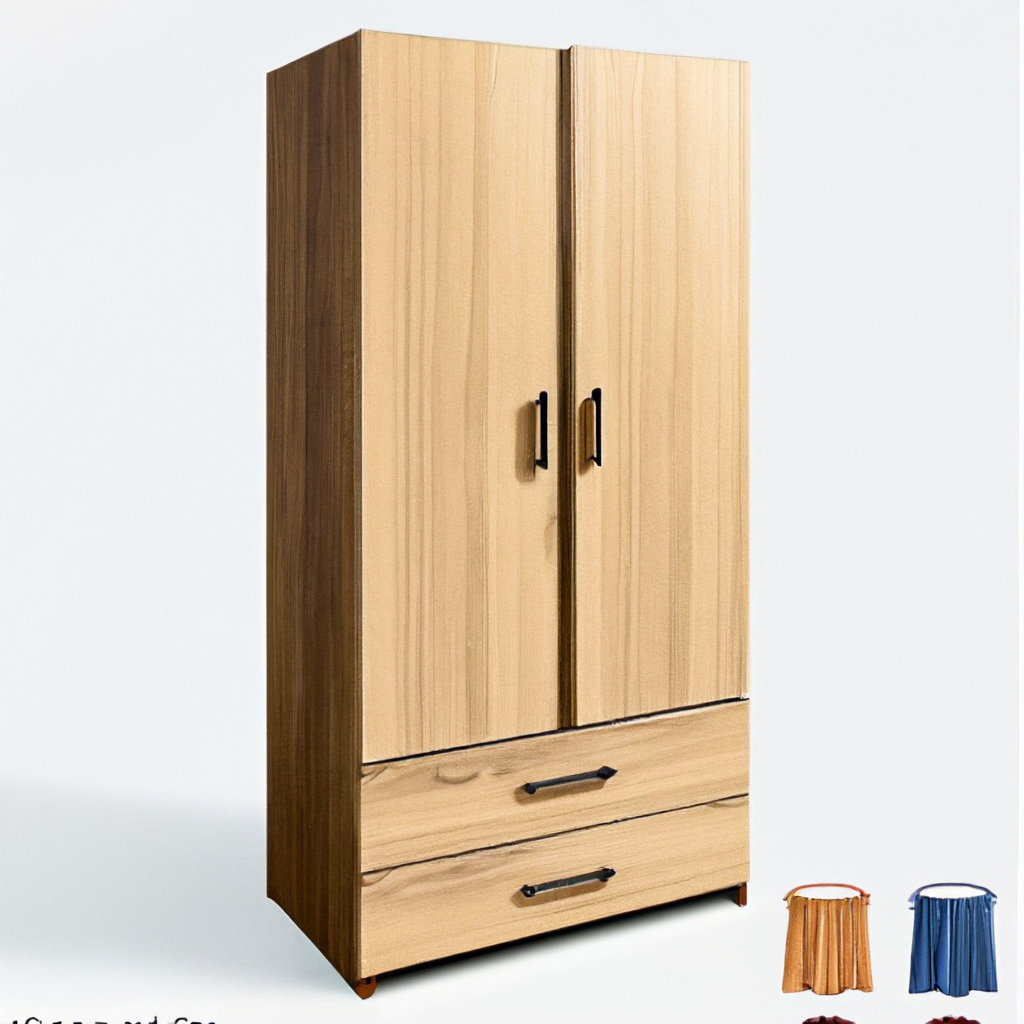

In [102]:
pil_image[0]

## Saving the last generated image

In [103]:
%cd /kaggle/working/
pil_image[0].save("wardrobe.png","PNG")

/kaggle/working


## Start the processing from 2D to 3D

In [1]:
!sudo apt update --yes

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
E: Repository 'http://packages.cloud.google.com/apt gcsfuse-focal InRelease' changed its 'Origin' value from 'gcsfuse-jessie' to 'gcsfuse-focal'
E: Repository 'http://packages.cloud.google.com/apt gcsfuse-focal InRelease' changed its 'Label' value from 'gcsfuse-jessie' to 'gcsfuse-focal'
N: This must be accepted explicitly before updates for this repository can be applied. See apt-secure(8) manpage for details.
Do you want to accept these changes and continue updating from this repository? [y/N] Y
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1068 kB]
Get:6 http://packages.cloud.google.com/apt gcsfuse-focal/ma

In [2]:
%cd /kaggle/working
!git clone -b dev https://github.com/camenduru/Wonder3D

!apt -y install -qq aria2
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Wonder3D/resolve/main/random_states_0.pkl -d /kaggle/working/Wonder3D/ckpts -o random_states_0.pkl
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Wonder3D/resolve/main/scaler.pt -d /kaggle/working/Wonder3D/ckpts -o scaler.pt
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Wonder3D/resolve/main/scheduler.bin -d /kaggle/working/Wonder3D/ckpts -o scheduler.bin
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Wonder3D/resolve/main/unet/diffusion_pytorch_model.bin -d /kaggle/working/Wonder3D/ckpts/unet -o diffusion_pytorch_model.bin
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Wonder3D/raw/main/unet/config.json -d /kaggle/working/Wonder3D/ckpts/unet -o config.json
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/segment_anything/resolve/main/sam_vit_h_4b8939.pth -d /kaggle/working/Wonder3D/sam_pt -o sam_vit_h_4b8939.pth
    
!pip install -q torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 torchtext==0.16.0 torchdata==0.7.0 --extra-index-url https://download.pytorch.org/whl/cu118 -U
!rm -rf /opt/conda/lib/python3.10/site-packages/typing_extensions-4.6.3.dist-info /opt/conda/lib/python3.10/site-packages/typing_extensions
!rm -rf /opt/conda/lib/python3.10/site-packages/anyio-3.7.0.dist-info /opt/conda/lib/python3.10/site-packages/anyio
!pip install -q fire diffusers==0.19.3 transformers bitsandbytes accelerate gradio rembg segment_anything
!pip install -q einops omegaconf pytorch-lightning==1.9.5 torch_efficient_distloss nerfacc==0.3.3 PyMCubes trimesh
!pip install -q https://download.pytorch.org/whl/cu118/xformers-0.0.22.post4%2Bcu118-cp310-cp310-manylinux2014_x86_64.whl
!pip install -q https://huggingface.co/camenduru/CoDeF/resolve/main/tinycudann-1.7-cp310-cp310-linux_x86_64.whl
!pip install -q scikit-image==0.19.3 imageio==2.31.6 imageio-ffmpeg==0.4.9
!git clone https://huggingface.co/camenduru/torch_extensions_0_3_3_kaggle /root/.cache/torch_extensions

/kaggle/working
Cloning into 'Wonder3D'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 244 (delta 45), reused 38 (delta 38), pack-reused 159 (from 1)
Receiving objects: 100% (244/244), 59.76 MiB | 51.94 MiB/s, done.
Resolving deltas: 100% (65/65), done.
The following additional packages will be installed:
  libaria2-0 libc-ares2 libssh2-1
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2 libssh2-1
0 upgraded, 4 newly installed, 0 to remove and 202 not upgraded.
Need to get 1622 kB of archives.
After this operation, 5817 kB of additional disk space will be used.

78Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 113818 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress

In [3]:
!pip install huggingface_hub==0.24.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.26.1
    Uninstalling huggingface-hub-0.26.1:
      Successfully uninstalled huggingface-hub-0.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.3.0 requires huggingface-hub>=0.25.1, but you have huggingface-hub 0.24.7 which is incompatible.


In [4]:
%cd /kaggle/working/Wonder3D
!accelerate launch --config_file 1gpu.yaml test_mvdiffusion_seq.py --config /kaggle/working/Wonder3D/configs/mvdiffusion-joint-ortho-6views.yaml

/kaggle/working/Wonder3D
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
{'pretrained_model_name_or_path': 'lambdalabs/sd-image-variations-diffusers', 'pretrained_unet_path': './ckpts/', 'revision': None, 'validation_dataset': {'root_dir': './example_images', 'num_views': 6, 'bg_color': 'white', 'img_wh': [256, 256], 'num_validation_samples': 1000, 'crop_size': 192, 'filepaths': ['owl.png']}, 'save_dir': 'outputs/', 'pred_type': 'joint', 'seed': 42, 'validation_batch_size': 1, 'dataloader_num_workers': 64, 'local_rank': -1, 'pipe_kwargs': {'c

## Loading a png for the inference

In [5]:
%cd /kaggle/working/Wonder3D
!accelerate launch --config_file 1gpu.yaml test_mvdiffusion_seq.py --config configs/mvdiffusion-joint-ortho-6views.yaml validation_dataset.root_dir={"/kaggle/working/"} validation_dataset.filepaths=['wardrobe.png'] save_dir={"/kaggle/working/Wonder3D/outputs"}

/kaggle/working/Wonder3D
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
{'pretrained_model_name_or_path': 'lambdalabs/sd-image-variations-diffusers', 'pretrained_unet_path': './ckpts/', 'revision': None, 'validation_dataset': {'root_dir': '/kaggle/input/mgai-wardrobe', 'num_views': 6, 'bg_color': 'white', 'img_wh': [256, 256], 'num_validation_samples': 1000, 'crop_size': 192, 'filepaths': ['wardrobe.png']}, 'save_dir': '/kaggle/working/Wonder3D/outputs', 'pred_type': 'joint', 'seed': 42, 'validation_batch_size': 1, 'dataloader_num_workers': 

## Mesh extraction

In [6]:
%cd /kaggle/working/Wonder3D/instant-nsr-pl

!python launch.py --config configs/neuralangelo-ortho-wmask.yaml --gpu 0 --train dataset.root_dir="/kaggle/working/Wonder3D/outputs/cropsize-192-cfg3.0" dataset.scene={"wardrobe"}

/kaggle/working/Wonder3D/instant-nsr-pl
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/kaggle/working/Wonder3D/outputs/cropsize-192-cfg3.0/wardrobe
(1024, 1024, 3)
the loaded normals are defined in the system of front view
/kaggle/working/Wonder3D/outputs/cropsize-192-cfg3.0/wardrobe
(1024, 1024, 3)
the loaded normals are defined in the system of front view
/kaggle/working/Wonder3D/outputs/cropsize-192-cfg3.0/wardrobe
(1024, 1024, 3)
the loaded normals are defined in the system of front vi